In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
from scipy.stats import ttest_ind
from numba import njit, jit
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
meta = pd.read_csv('../data/META_SL.csv')

In [3]:
meta['plat'].unique()

array(['Agilent', 'Illumina_NGS', 'Affymetrix_U133', 'Illumina_Chip',
       'Affymetrix_HUG', 'Affymetrix_PRV'], dtype=object)

In [4]:
meta

,CN,type,plat,TP
0,C_1,Solid tumor,Agilent,Solid tumor_Agilent
1,C_2,Solid tumor,Agilent,Solid tumor_Agilent
2,C_3,Solid tumor,Agilent,Solid tumor_Agilent
3,C_4,Solid tumor,Agilent,Solid tumor_Agilent
4,C_5,Solid tumor,Agilent,Solid tumor_Agilent
...,...,...,...,...
7162,C_7163,C,Affymetrix_PRV,C_Affymetrix_PRV
7163,C_7164,D,Affymetrix_PRV,D_Affymetrix_PRV
7164,C_7165,D,Affymetrix_PRV,D_Affymetrix_PRV
7165,C_7166,D,Affymetrix_PRV,D_Affymetrix_PRV


#### Данные, на которых нужно проверить гипотезу

In [5]:
data = pd.read_csv('../data/60.csv')

In [6]:
data.head()

,S9bcbf828_bd0c_4a71_8021_7a262de8978c,S23ea1a02_938c_47cc_8a7d_abd33db1f305,Sddfe7bdf_0d22_4f98_b712_09df67794990,Sb80aec3c_742c_4e9d_b45b_53809b6b80f1,S988b3794_2640_4ff6_a739_d473adbca3e8,S5d095a36_74db_44ec_bca2_35af7a47f1c5,S97e6b861_062c_4235_8f12_db621f22e353,S9120d8d8_8605_493d_a963_7642852778c4,S10aa11ee_6df1_42f6_bc32_6ffed2e7d25c,S3e1fc047_a69e_469b_a005_33b208fdbfd3,...,AFX_GPL16043_B_3,AFX_GPL16043_B_4,AFX_GPL16043_C_1,AFX_GPL16043_C_2,AFX_GPL16043_C_3,AFX_GPL16043_C_4,AFX_GPL16043_D_1,AFX_GPL16043_D_2,AFX_GPL16043_D_3,AFX_GPL16043_D_4
A2M,15970.293687,11873.652111,12352.443470,24831.023835,20460.734499,13667.761589,15795.301397,15698.925094,16869.458452,8994.636329,...,13820.375283,13737.902193,60568.248321,59823.742454,59870.783060,61120.739501,45504.536760,34690.108246,46013.722118,45456.606466
AACS,2167.771333,1852.317362,2009.629547,1997.631407,1990.424484,1814.595749,1724.067094,1880.985885,2162.165560,2240.573618,...,728.369954,705.970445,512.293288,482.426263,481.590406,491.873324,568.618736,585.571875,551.140823,529.447041
AAK1,353.942791,380.309134,270.951502,257.074323,271.282898,232.576863,244.740497,283.151657,258.221363,447.807641,...,10525.411202,9721.330646,2940.282920,2519.896959,2397.411214,2572.982842,6330.411737,6670.038491,7125.659959,7627.979769
AAMP,4071.211655,3467.334905,3608.161826,4132.052869,5768.112881,3419.390336,3494.785372,3442.336804,4540.182016,6444.440387,...,2980.070728,3415.565842,3049.898102,3164.678214,2941.157576,3176.174285,3157.099033,3296.901461,3290.772077,3390.208199
AASDHPPT,1980.434441,2318.499070,2202.791035,1805.950856,1601.361527,2254.925207,2199.695794,2426.909790,1985.387675,1589.265310,...,4539.254347,4562.652157,4068.207090,4228.815441,3445.788052,3204.345943,4603.446199,4574.670634,4571.040524,4773.573417


In [7]:
data.columns = meta['CN']

In [8]:
data.head()

CN,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,...,C_7158,C_7159,C_7160,C_7161,C_7162,C_7163,C_7164,C_7165,C_7166,C_7167
A2M,15970.293687,11873.652111,12352.443470,24831.023835,20460.734499,13667.761589,15795.301397,15698.925094,16869.458452,8994.636329,...,13820.375283,13737.902193,60568.248321,59823.742454,59870.783060,61120.739501,45504.536760,34690.108246,46013.722118,45456.606466
AACS,2167.771333,1852.317362,2009.629547,1997.631407,1990.424484,1814.595749,1724.067094,1880.985885,2162.165560,2240.573618,...,728.369954,705.970445,512.293288,482.426263,481.590406,491.873324,568.618736,585.571875,551.140823,529.447041
AAK1,353.942791,380.309134,270.951502,257.074323,271.282898,232.576863,244.740497,283.151657,258.221363,447.807641,...,10525.411202,9721.330646,2940.282920,2519.896959,2397.411214,2572.982842,6330.411737,6670.038491,7125.659959,7627.979769
AAMP,4071.211655,3467.334905,3608.161826,4132.052869,5768.112881,3419.390336,3494.785372,3442.336804,4540.182016,6444.440387,...,2980.070728,3415.565842,3049.898102,3164.678214,2941.157576,3176.174285,3157.099033,3296.901461,3290.772077,3390.208199
AASDHPPT,1980.434441,2318.499070,2202.791035,1805.950856,1601.361527,2254.925207,2199.695794,2426.909790,1985.387675,1589.265310,...,4539.254347,4562.652157,4068.207090,4228.815441,3445.788052,3204.345943,4603.446199,4574.670634,4571.040524,4773.573417


In [9]:
data = data.astype(float)

In [10]:
data.head()

CN,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,...,C_7158,C_7159,C_7160,C_7161,C_7162,C_7163,C_7164,C_7165,C_7166,C_7167
A2M,15970.293687,11873.652111,12352.443470,24831.023835,20460.734499,13667.761589,15795.301397,15698.925094,16869.458452,8994.636329,...,13820.375283,13737.902193,60568.248321,59823.742454,59870.783060,61120.739501,45504.536760,34690.108246,46013.722118,45456.606466
AACS,2167.771333,1852.317362,2009.629547,1997.631407,1990.424484,1814.595749,1724.067094,1880.985885,2162.165560,2240.573618,...,728.369954,705.970445,512.293288,482.426263,481.590406,491.873324,568.618736,585.571875,551.140823,529.447041
AAK1,353.942791,380.309134,270.951502,257.074323,271.282898,232.576863,244.740497,283.151657,258.221363,447.807641,...,10525.411202,9721.330646,2940.282920,2519.896959,2397.411214,2572.982842,6330.411737,6670.038491,7125.659959,7627.979769
AAMP,4071.211655,3467.334905,3608.161826,4132.052869,5768.112881,3419.390336,3494.785372,3442.336804,4540.182016,6444.440387,...,2980.070728,3415.565842,3049.898102,3164.678214,2941.157576,3176.174285,3157.099033,3296.901461,3290.772077,3390.208199
AASDHPPT,1980.434441,2318.499070,2202.791035,1805.950856,1601.361527,2254.925207,2199.695794,2426.909790,1985.387675,1589.265310,...,4539.254347,4562.652157,4068.207090,4228.815441,3445.788052,3204.345943,4603.446199,4574.670634,4571.040524,4773.573417


#### Код Стьюдента

In [11]:
rng = np.random.default_rng()

In [12]:
def get_splitted_columns(columns):
    shuffled = rng.permutation(columns)
    columns_1 = shuffled[:len(columns) // 2]
    columns_2 = shuffled[len(columns) // 2:]
    return columns_1, columns_2

In [13]:
def split_for_f(gene, columns_1, columns_2):
    sample_1 = gene[columns_1].values
    sample_2 = gene[columns_2].values
    return f(sample_1, sample_2)

$$
f_g = sign(\overline{D}_g - \overline{H}_g) \cdot (-lg(P_g))
$$

In [14]:
# @njit
def f(sample_1, sample_2):
    sign = np.sign(sample_1.mean() - sample_2.mean())
    p_value = ttest_ind(sample_1, sample_2)[1]
    return sign * (-np.log1p(p_value))

In [15]:
def calc_corr(data, fixed_cols, splitting_cols):
    cols_1, cols_2 = get_splitted_columns(splitting_cols)
    
    f_1 = data.apply(split_for_f, args=(fixed_cols, cols_1), axis=1)
    f_2 = data.apply(split_for_f, args=(fixed_cols, cols_2), axis=1)
    
    return f_1.corr(f_2)

In [16]:
%time calc_corr(data, plat_1, plat_2)

NameError: name 'plat_1' is not defined

#### Перебор всех пар платформ

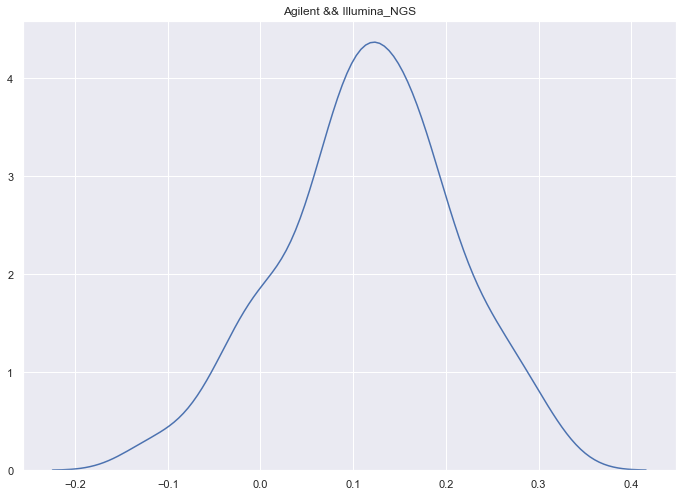

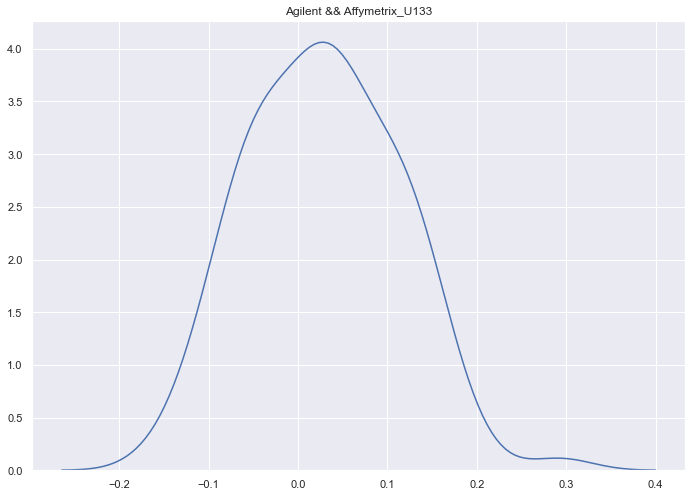

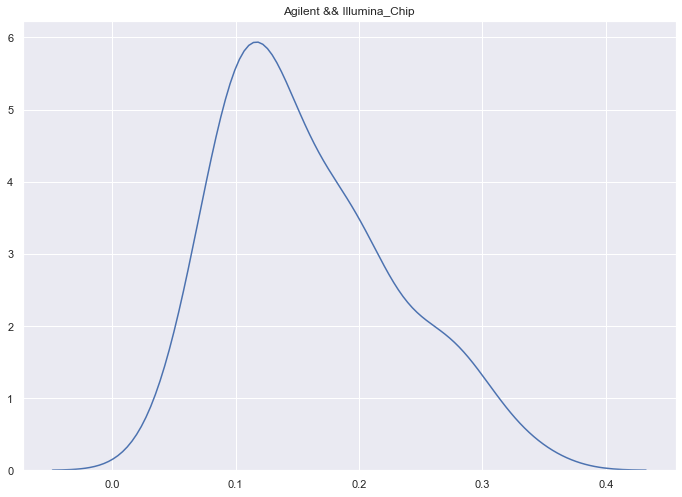

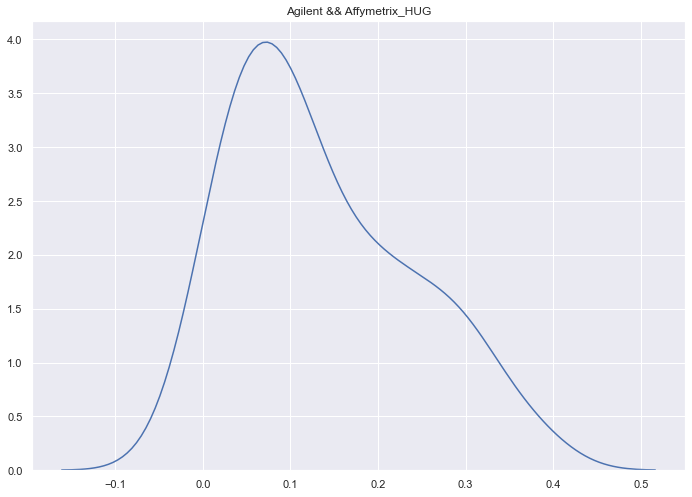

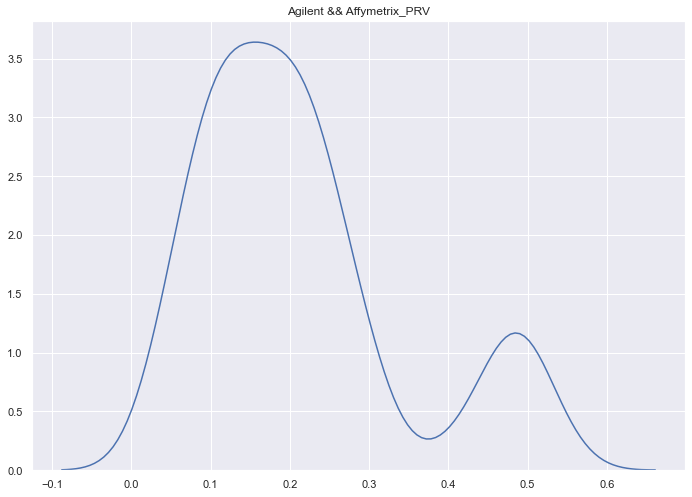

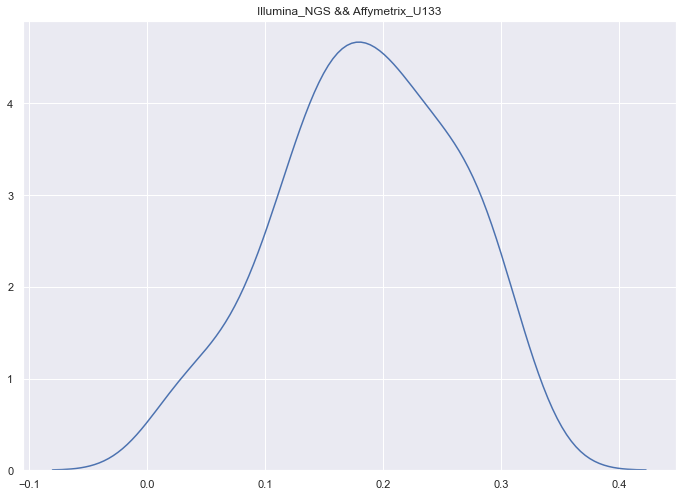

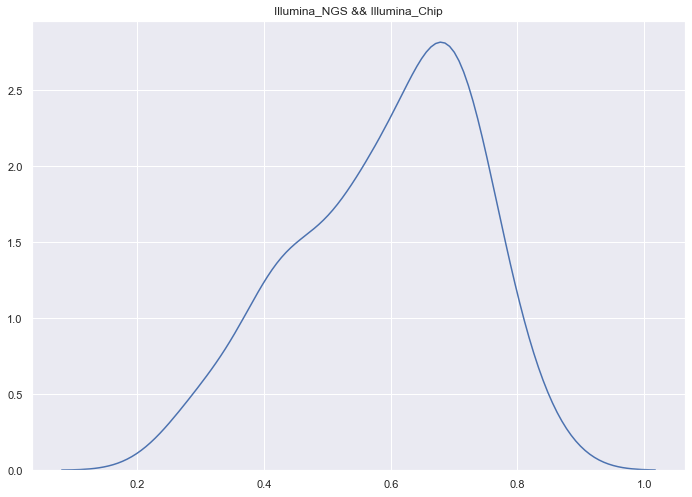

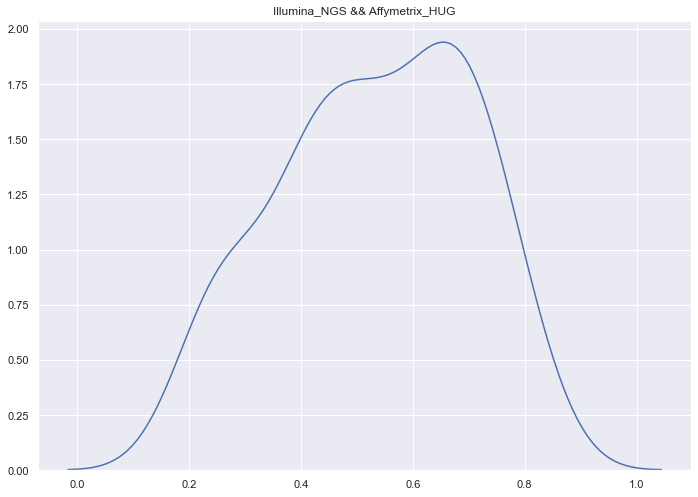

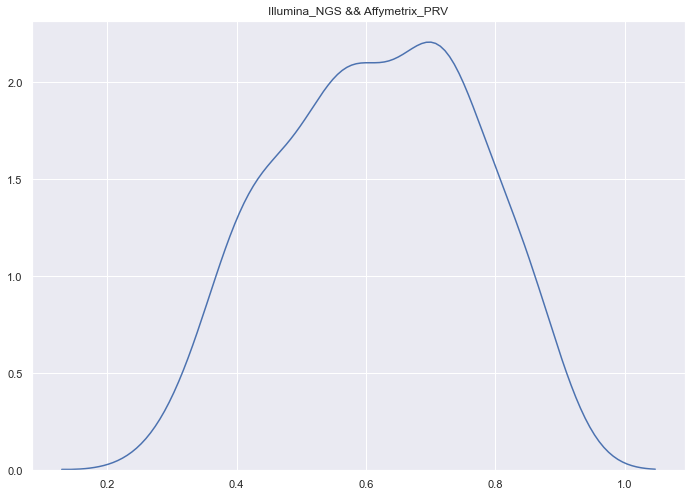

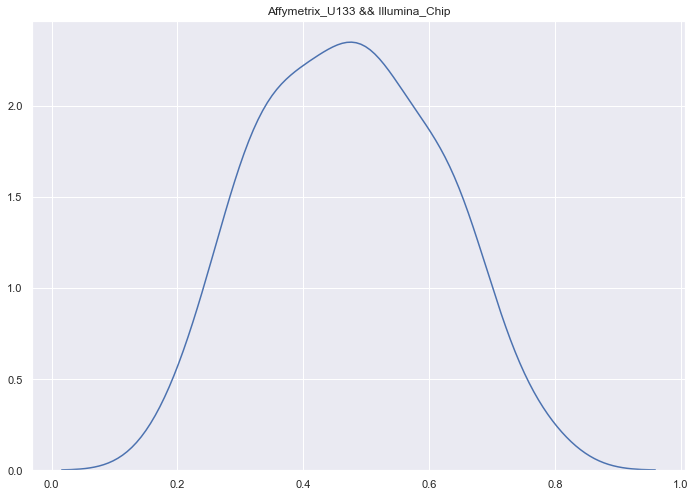

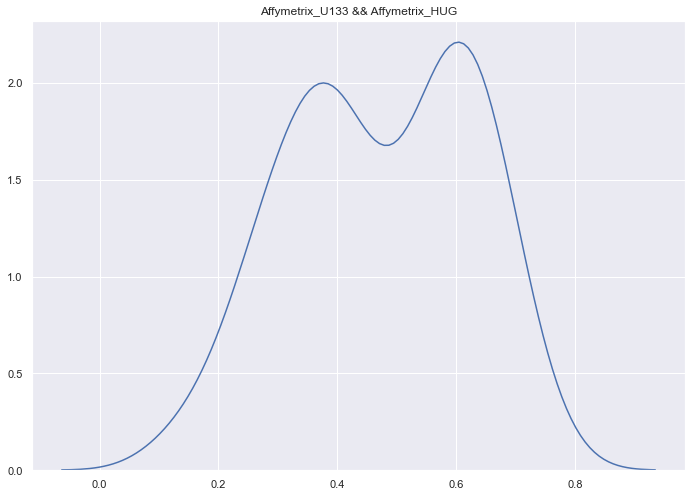

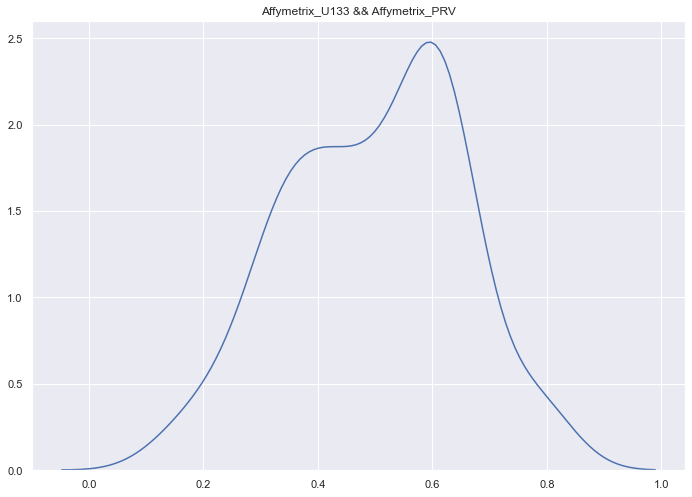

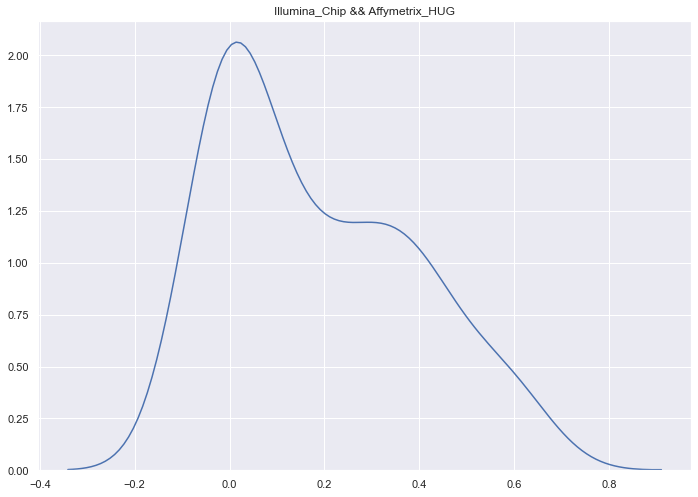

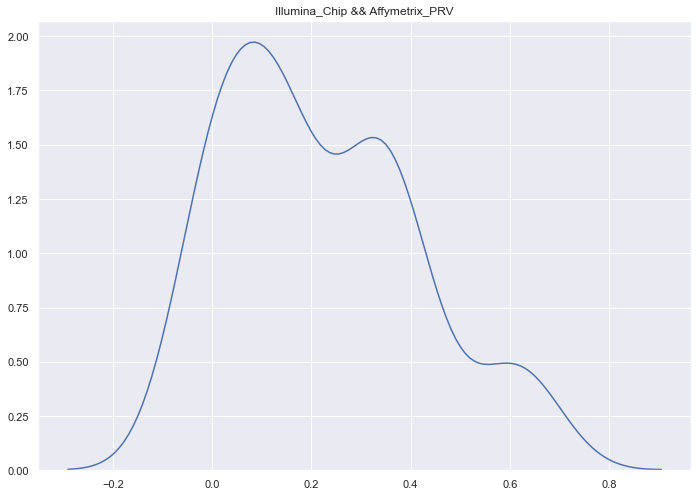

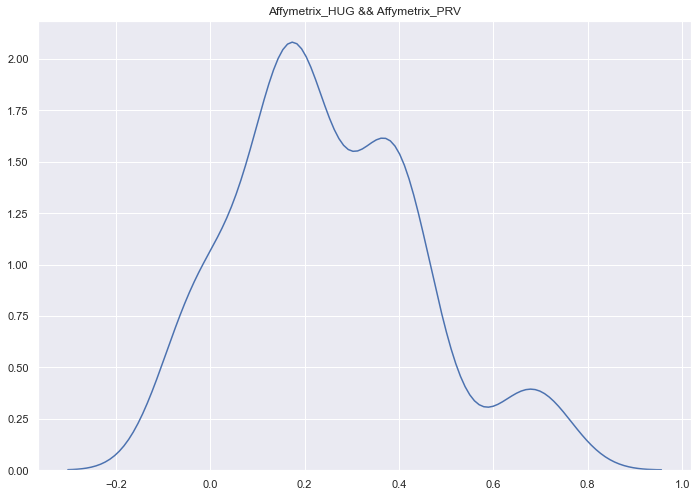

In [17]:
for idx_1, title_1 in enumerate(meta['plat'].unique()):
    for idx_2, title_2 in enumerate(meta['plat'].unique()):
        
        if(idx_2 > idx_1):
            
            plat_1 = meta[meta['plat'] == title_1]['CN']
            plat_2 = meta[meta['plat'] ==  title_2]['CN']
            
            corrs = [calc_corr(data, plat_1, plat_2) for i in range(100)]
            
            plt.figure()
            plt.title(title_1 + " && " + title_2)
            sns.distplot(corrs, hist=False)